In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

In [2]:
trace = pandas.read_csv("data/asha.log", sep=';')
trace["performance"] = -trace["score"].apply(lambda s: float(s[1:-1].split(',')[0]))
trace["rank"] = trace["performance"].rank(method='min')
trace["learner"] = trace["pipeline"].apply(lambda p: p.split('(')[0])

In [3]:
pipeline_traces = []
for pipeline in trace["id"].unique():
    evaluations = trace[trace["id"] == pipeline].sort_values("rung")
    if not numpy.isinf(evaluations["performance"]).any():
        pipeline_traces.append((list(evaluations["subsample"]), list(-evaluations["performance"]), list(evaluations["learner"])))
        

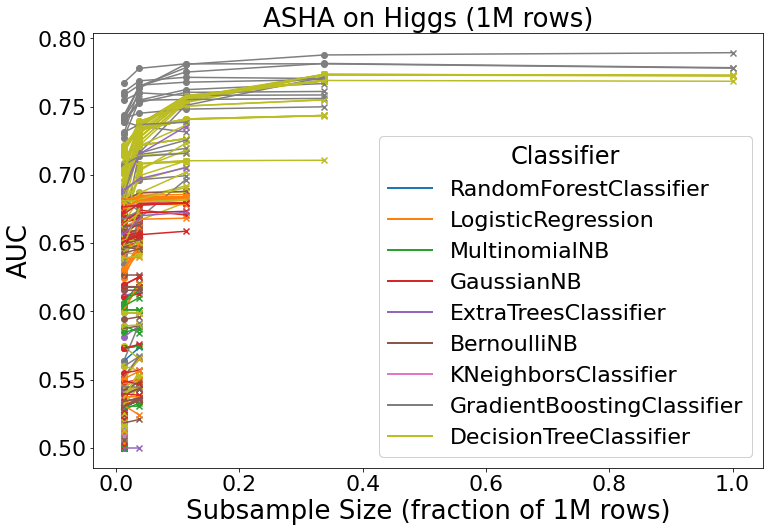

In [18]:
import matplotlib.cm

assert trace["learner"].nunique() <= 10
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
learners = trace["learner"].unique()
learner_to_color = dict(zip(learners, [matplotlib.cm.get_cmap("tab10")(i) for i in range(len(learners))]))

for rungs, performances, learner in pipeline_traces:
    c = learner_to_color[learner[0]]
    ax.scatter(rungs[:-1], performances[:-1], color=c)
    ax.scatter(rungs[-1], performances[-1], marker='x', color=c)
    ax.plot(rungs, performances, color=c)

#ax.set_yscale("log")
ax.set_ylabel("AUC", fontsize=26)
ax.set_xlabel("Subsample Size (fraction of 1M rows)", fontsize=26)
ax.set_title("ASHA on Higgs (1M rows)", fontdict=dict(fontsize=26))
ax.tick_params(axis='both', which = 'major', labelsize = 22)

from matplotlib.lines import Line2D
legend_elements = [
    *[Line2D([0], [0], color=color, lw=2, label=learner) for learner, color in learner_to_color.items()],
]
fig.gca().add_artist(
    ax.legend(handles=legend_elements, fontsize = 22, bbox_to_anchor=(1, 0), loc="lower right", 
             title="Classifier", title_fontsize=24)
)
legend_elements=[
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', label='promotion'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='k', label='non-promotion'),
]

# fig.gca().add_artist(
#     ax.legend(handles=legend_elements, fontsize = 22, bbox_to_anchor=(0.45, 0), loc="lower right", 
#              title="Status", title_fontsize=24)
# )
#ax.legend(handles=legend_elements, fontsize=22, ncol=2)

Note that a non-promotion can also mean it was not promoted *yet* (or was promoted but the evaluation in the new rung did not yet complete)>

In [19]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("asha.pdf") as f:
    f.savefig(fig,  bbox_inches='tight')